# 模型及其权重的保存和加载

## 导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import os

## 读取图片

In [2]:
from torchvision import transforms

# 定义数据增强方法
train_transform = transforms.Compose([
    transforms.Resize(112),                       # 将图片缩放到112
    transforms.RandomCrop(96),                    # 随机裁剪96
    transforms.RandomHorizontalFlip(),            # 随机水平翻转，默认概率为0.5
    transforms.RandomRotation(0.2),               # 随机旋转0.2弧度
    transforms.ColorJitter(brightness=0.5),       # 亮度调整
    transforms.ColorJitter(contrast=0.5),         # 对比度调整
    transforms.ToTensor(),                        # 将图片转换为张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])      # 将图片的每个通道的像素值减去均值，再除以标准差，使像素值均值为0，标准差为1
])

# 测试集不需要数据增强
test_transform = transforms.Compose([
    transforms.Resize((96, 96)),                # 将图片缩放到96，96
    transforms.ToTensor(),                        # 将图片转换为张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])      # 将图片的每个通道的像素值减去均值，再除以标准差，使像素值均值为0，标准差为1
])

In [3]:
base_dir = r'./dataset/4weather'
train_dir = os.path.join(base_dir , 'train')
test_dir = os.path.join(base_dir , 'test')
# 读取训练集和测试集的图片
train_ds = torchvision.datasets.ImageFolder(
               train_dir,
               transform=train_transform
)
test_ds = torchvision.datasets.ImageFolder(
               test_dir,
               transform=test_transform
)

## 加载数据

In [4]:
# 加载数据集，划分批次
torch.backends.cudnn.benchmark = True           # 开启CUDNN加速
BATCHSIZE = 32
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BATCHSIZE,
                                       shuffle=True,
                                       num_workers=2,           # 使用2个进程加载数据
                                       prefetch_factor=2,       # 预取的批次数量，默认为2
                                       pin_memory=True,         # 将数据固定在GPU内存中，加速数据传输
                                       persistent_workers=True, # 持久化加载器，在数据加载器关闭后，仍然保持进程运行，提高数据加载效率

)
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BATCHSIZE,
                                       num_workers=2,           # 使用2个进程加载数据
                                       prefetch_factor=2,       # 预取的批次数量，默认为2
                                       pin_memory=True,         # 将数据固定在GPU内存中，加速数据传输
                                       persistent_workers=True, # 持久化加载器，在数据加载器关闭后，仍然保持进程运行，提高数据加载效率
)

## 构建模型

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=16)                            # 在conv层之后添加BatchNorm层，num_features为卷积层的输出通道数
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop = nn.Dropout(0.3)                         # 在linker层之间添加dropout层：随机丢弃30%的神经元，防止过拟合
        self.fc1 = nn.Linear(64*10*10, 1024)                # 64*10*10
        self.bn_fc1 = nn.BatchNorm1d(num_features=1024)     # 在linker层之后添加BatchNorm层，num_features为linker层的输出通道数
        self.fc2 = nn.Linear(1024, 256)
        self.bn_fc2 = nn.BatchNorm1d(num_features=256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.bn1(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.bn2(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.bn3(x)

        # print(x.size())     # [batch, channel, hight, width]   [16, 64, 10, 10]

        x = x.view(-1, 64*10*10)       # 64*10*10
        x = F.relu(self.fc1(x))
        x = self.bn_fc1(x)
        x = self.drop(x)            # linear层之间添加dropout层
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        x = self.drop(x)            # linear层之间添加dropout层
        x = self.fc3(x)
        return x
        

## 训练模型

In [6]:
# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model = Model().to(device) # 将已实例化的模型移动到GPU上

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.Adam(model.parameters(), lr=0.001) # 优化器，Adam优化器，学习率为0.001
epochs = 10

# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl: # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt)

Epoch: 0, Train Loss: 0.8744, Train Acc: 66.11%, Test Loss: 0.7157, Test Acc: 65.78%
Epoch: 1, Train Loss: 0.6569, Train Acc: 76.67%, Test Loss: 0.3873, Test Acc: 87.56%
Epoch: 2, Train Loss: 0.5806, Train Acc: 78.89%, Test Loss: 0.4164, Test Acc: 84.00%
Epoch: 3, Train Loss: 0.5766, Train Acc: 79.89%, Test Loss: 0.3285, Test Acc: 85.78%
Epoch: 4, Train Loss: 0.5071, Train Acc: 82.00%, Test Loss: 0.4288, Test Acc: 84.00%
Epoch: 5, Train Loss: 0.4599, Train Acc: 82.11%, Test Loss: 0.4430, Test Acc: 80.00%
Epoch: 6, Train Loss: 0.4215, Train Acc: 84.44%, Test Loss: 0.3248, Test Acc: 86.67%
Epoch: 7, Train Loss: 0.4589, Train Acc: 84.11%, Test Loss: 0.3129, Test Acc: 89.33%
Epoch: 8, Train Loss: 0.3816, Train Acc: 85.22%, Test Loss: 0.2927, Test Acc: 88.89%
Epoch: 9, Train Loss: 0.3009, Train Acc: 87.78%, Test Loss: 0.3262, Test Acc: 86.67%


## 可视化训练结果

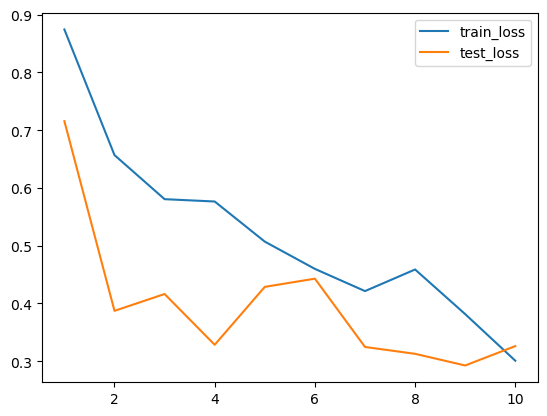

In [7]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

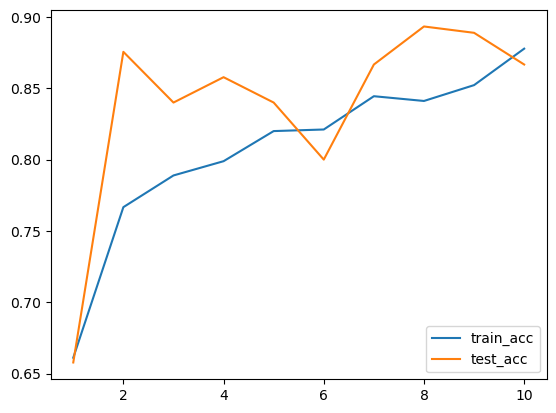

In [8]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

## 保存和加载模型

In [9]:
# 保存模型
model_path = './model/custom_model_for_4weather.pth'
torch.save(model.state_dict(), model_path) # 保存模型参数

In [10]:
# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
load_model = Model()
# load_model.load_state_dict(torch.load(model_path)) # 加载模型参数
load_model.load_state_dict(torch.load(model_path, map_location=device)) # 跨设备加载模型参数，map_location参数指定加载模型参数的设备，如'cpu'或'cuda'
load_model.to(device) # 将模型移动到GPU上

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (bn_fc1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (bn_fc2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [11]:
# 测试载入的模型
test_correct = 0
test_total = 0

load_model.eval()

with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上
        y_pred = load_model(x)
        y_pred = torch.argmax(y_pred, dim=1)
        test_correct += (y_pred == y).sum().item()
        test_total += y.size(0)
    
epoch_test_acc = test_correct / test_total
print(epoch_test_acc)

0.8666666666666667


## 训练过程中保存模型最优参数

In [12]:
import copy

new_model = Model().to(device)
opt = torch.optim.Adam(new_model.parameters(), lr=0.001) # 优化器，Adam优化器，学习率为0.001


# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    best_acc = 0.0
    best_model_weight = copy.deepcopy(new_model.state_dict())

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            best_model_weight = copy.deepcopy(model.state_dict())

    return best_model_weight, train_loss, train_acc, test_loss, test_acc

# 训练
best_model_weight, train_loss, train_acc, test_loss, test_acc = fit(epochs, new_model, train_dl, test_dl, loss_fn, opt)

Epoch: 0, Train Loss: 0.8313, Train Acc: 68.11%, Test Loss: 0.9326, Test Acc: 56.89%
Epoch: 1, Train Loss: 0.6427, Train Acc: 76.00%, Test Loss: 0.4403, Test Acc: 82.22%
Epoch: 2, Train Loss: 0.5431, Train Acc: 79.22%, Test Loss: 0.3678, Test Acc: 84.44%
Epoch: 3, Train Loss: 0.4670, Train Acc: 81.78%, Test Loss: 0.3085, Test Acc: 86.22%
Epoch: 4, Train Loss: 0.5066, Train Acc: 81.89%, Test Loss: 0.3421, Test Acc: 86.67%
Epoch: 5, Train Loss: 0.4625, Train Acc: 82.67%, Test Loss: 0.2855, Test Acc: 88.44%
Epoch: 6, Train Loss: 0.3857, Train Acc: 85.67%, Test Loss: 0.2356, Test Acc: 90.67%
Epoch: 7, Train Loss: 0.5134, Train Acc: 81.78%, Test Loss: 0.2550, Test Acc: 90.67%
Epoch: 8, Train Loss: 0.3671, Train Acc: 85.89%, Test Loss: 0.2463, Test Acc: 88.89%
Epoch: 9, Train Loss: 0.3998, Train Acc: 85.89%, Test Loss: 0.3293, Test Acc: 88.44%


In [13]:
# 将参数赋值给模型
new_model.load_state_dict(best_model_weight) # 加载模型参数
new_model.eval() # 设置模型为评估预测模式，便于后续使用

# 测试训练后的的模型
test_correct = 0
test_total = 0

with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上
        y_pred = new_model(x)
        y_pred = torch.argmax(y_pred, dim=1)
        test_correct += (y_pred == y).sum().item()
        test_total += y.size(0)
    
epoch_test_acc = test_correct / test_total
print(epoch_test_acc)

0.9066666666666666
